<a href="https://colab.research.google.com/github/vikpy/DLSem3/blob/master/Assignment_10_Multi_Window_Single_Shot_Time_Series_Model_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assigment 10: Train autoregressive model using RNN, LSTM, GRU (unidirectional) - on multi_window**


Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


mpl.rcParams['axes.grid'] = False

#Extracting the data from the source

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


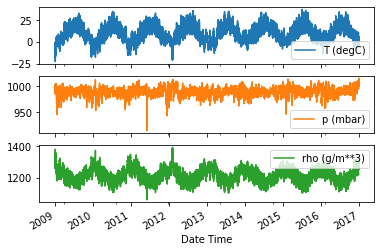

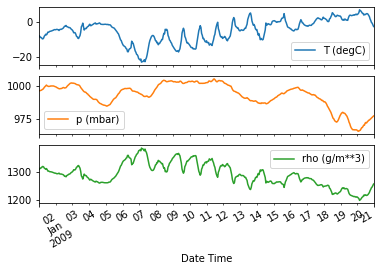

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

#Some Preprocessing 

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

In [8]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

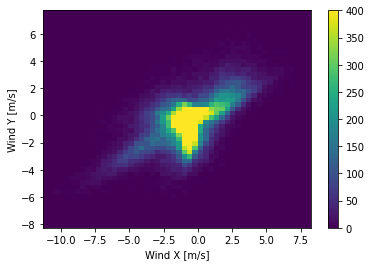

In [9]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [10]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [11]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

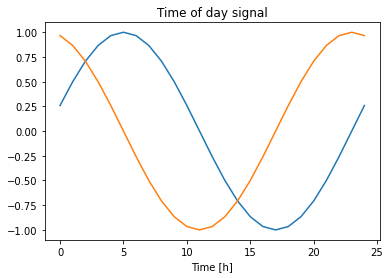

In [12]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

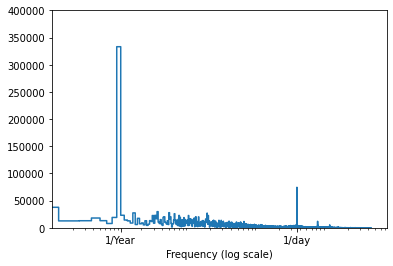

In [13]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

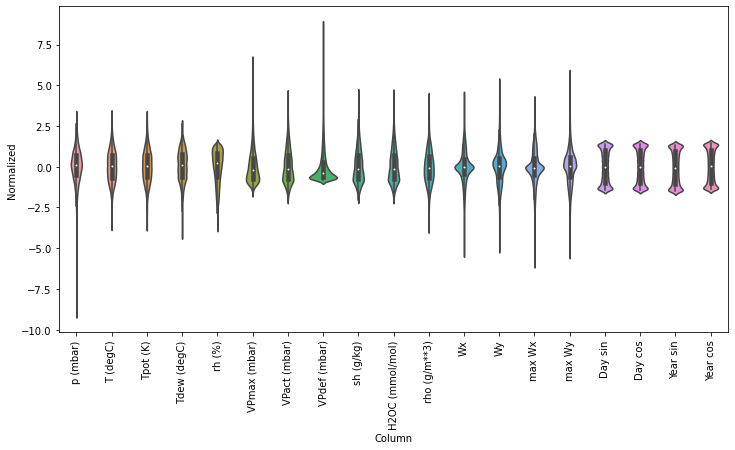

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

#Defining the helper functions

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [22]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

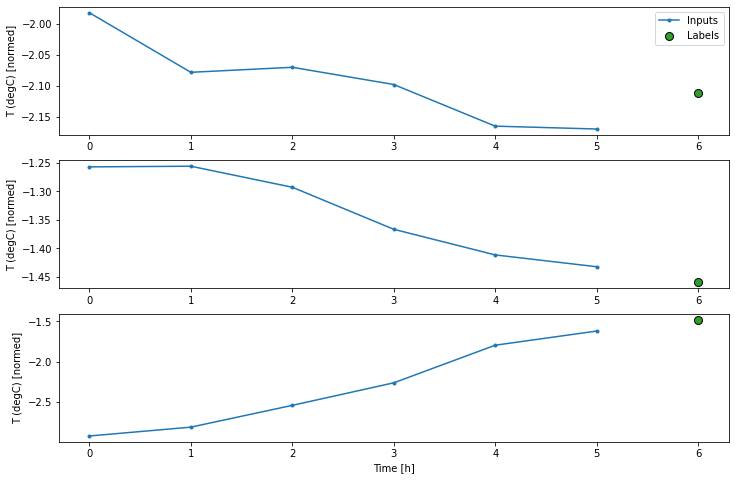

In [25]:
w2.plot()

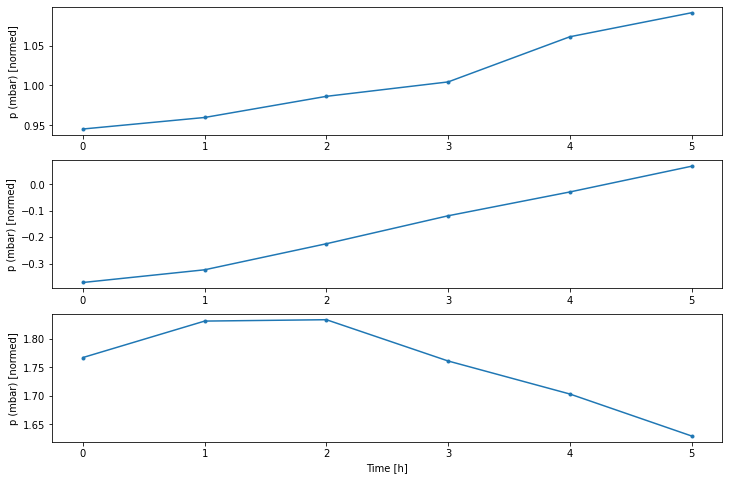

In [26]:
w2.plot(plot_col='p (mbar)')

In [29]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [31]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [27]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

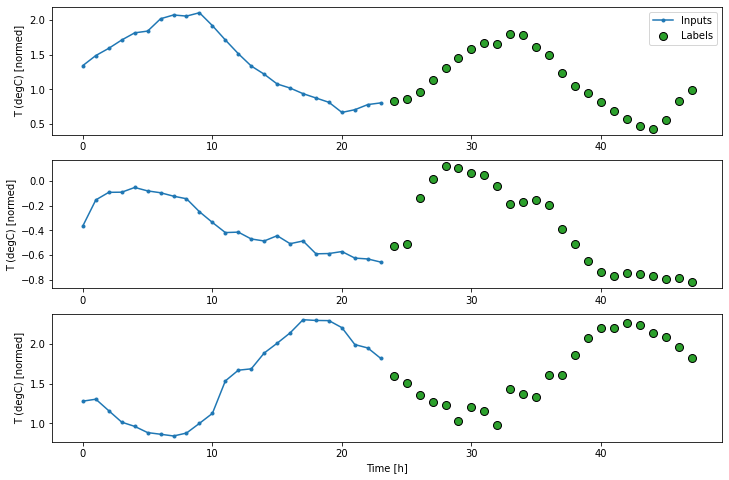

In [32]:

OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#Applying the RNN/LSTM/GRU 

In [36]:
# For tracking performance of the model for all the three models

val_performance = {}
performance = {}



#Simple RNN

In [37]:
#Simple RNN 

simple_rnn = tf.keras.models.Sequential([
                               tf.keras.layers.SimpleRNN(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=1)   
])

simple_rnn.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_rnn.fit(multi_window.train, epochs=10, validation_data=multi_window.val)
val_performance['simple rnn'] = simple_rnn.evaluate(multi_window.val)
performance['simple rnn'] = simple_rnn.evaluate(multi_window.test)

Epoch 1/10
1532/1532 [==============================] - 13s 8ms/step - loss: 0.9348 - mean_absolute_error: 0.7724 - val_loss: 0.8782 - val_mean_absolute_error: 0.7455
Epoch 2/10
1532/1532 [==============================] - 12s 8ms/step - loss: 0.9267 - mean_absolute_error: 0.7691 - val_loss: 0.8769 - val_mean_absolute_error: 0.7450
Epoch 3/10
1532/1532 [==============================] - 13s 8ms/step - loss: 0.9258 - mean_absolute_error: 0.7688 - val_loss: 0.8770 - val_mean_absolute_error: 0.7460
Epoch 4/10
1532/1532 [==============================] - 12s 8ms/step - loss: 0.9252 - mean_absolute_error: 0.7686 - val_loss: 0.8762 - val_mean_absolute_error: 0.7446
Epoch 5/10
1532/1532 [==============================] - 12s 8ms/step - loss: 0.9249 - mean_absolute_error: 0.7685 - val_loss: 0.8760 - val_mean_absolute_error: 0.7460
Epoch 6/10
1532/1532 [==============================] - 12s 8ms/step - loss: 0.9246 - mean_absolute_error: 0.7684 - val_loss: 0.8767 - val_mean_absolute_error: 0.745

# LSTM

In [38]:
simple_lstm = tf.keras.models.Sequential([
                               tf.keras.layers.LSTM(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=1)   
])

simple_lstm.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_lstm.fit(multi_window.train, epochs=10, validation_data=multi_window.val)

val_performance['simple lstm'] = simple_lstm.evaluate(multi_window.val)
performance['simple lstm'] = simple_lstm.evaluate(multi_window.test)

Epoch 1/10
1532/1532 [==============================] - 21s 14ms/step - loss: 0.9277 - mean_absolute_error: 0.7695 - val_loss: 0.8751 - val_mean_absolute_error: 0.7449
Epoch 2/10
1532/1532 [==============================] - 20s 13ms/step - loss: 0.9237 - mean_absolute_error: 0.7679 - val_loss: 0.8749 - val_mean_absolute_error: 0.7455
Epoch 3/10
1532/1532 [==============================] - 21s 13ms/step - loss: 0.9221 - mean_absolute_error: 0.7673 - val_loss: 0.8767 - val_mean_absolute_error: 0.7467
Epoch 4/10
1532/1532 [==============================] - 20s 13ms/step - loss: 0.9207 - mean_absolute_error: 0.7668 - val_loss: 0.8773 - val_mean_absolute_error: 0.7454
Epoch 5/10
1532/1532 [==============================] - 20s 13ms/step - loss: 0.9195 - mean_absolute_error: 0.7663 - val_loss: 0.8774 - val_mean_absolute_error: 0.7457
Epoch 6/10
1532/1532 [==============================] - 20s 13ms/step - loss: 0.9185 - mean_absolute_error: 0.7659 - val_loss: 0.8783 - val_mean_absolute_error:

#Simple GRU

In [39]:
simple_gru = tf.keras.models.Sequential([
                               tf.keras.layers.GRU(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=1)   
])

simple_gru.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_gru.fit(multi_window.train, epochs=10, validation_data=multi_window.val)

val_performance['simple gru'] = simple_gru.evaluate(multi_window.val)
performance['simple gru'] = simple_gru.evaluate(multi_window.test)

Epoch 1/10
1532/1532 [==============================] - 20s 13ms/step - loss: 0.9343 - mean_absolute_error: 0.7719 - val_loss: 0.8741 - val_mean_absolute_error: 0.7436
Epoch 2/10
1532/1532 [==============================] - 21s 14ms/step - loss: 0.9249 - mean_absolute_error: 0.7684 - val_loss: 0.8743 - val_mean_absolute_error: 0.7449
Epoch 3/10
1532/1532 [==============================] - 21s 14ms/step - loss: 0.9241 - mean_absolute_error: 0.7680 - val_loss: 0.8745 - val_mean_absolute_error: 0.7457
Epoch 4/10
1532/1532 [==============================] - 21s 13ms/step - loss: 0.9232 - mean_absolute_error: 0.7677 - val_loss: 0.8743 - val_mean_absolute_error: 0.7454
Epoch 5/10
1532/1532 [==============================] - 20s 13ms/step - loss: 0.9223 - mean_absolute_error: 0.7673 - val_loss: 0.8759 - val_mean_absolute_error: 0.7470
Epoch 6/10
1532/1532 [==============================] - 20s 13ms/step - loss: 0.9216 - mean_absolute_error: 0.7670 - val_loss: 0.8759 - val_mean_absolute_error:

#Comparing the models

In [41]:
mpl.rcParams['figure.figsize'] = (10, 10)

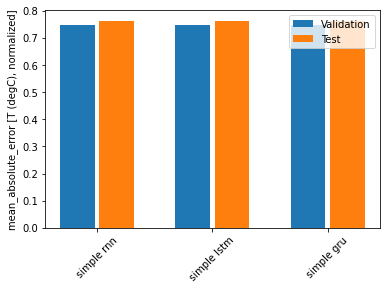

In [40]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = simple_rnn.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
